In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from progressbar import progressbar as pbar
from scipy import stats
from local.lib import histos2d as h2
%matplotlib inline

## `tensorflow` optimizer for linear regression

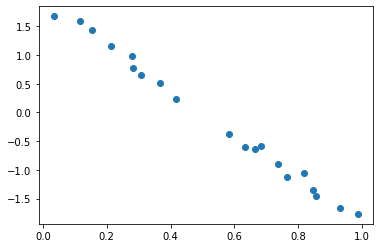

In [2]:
a,b = -4,2
x = np.random.random(size=20)
y = x*a+b+np.random.normal(size=20)*.1
plt.scatter(x,y)

In [3]:
pa = tf.Variable(initial_value=[np.random.random()], name="a", dtype=tf.float64)
pb = tf.Variable(initial_value=[np.random.random()], name="b", dtype=tf.float64)

In [4]:
def loss(pa,pb):
    tf.reduce_mean((x*pa+b-y)**2)

In [5]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss_value = tf.reduce_mean((x*pa+pb-y)**2)
    grads = tape.gradient(loss_value, [pa, pb])

    optimizer.apply_gradients(zip(grads, [pa, pb]))
    return loss_value

h = []
for epoch in range(10000):
    loss_value = train_step()
    h.append(loss_value.numpy())

In [6]:
loss_value

<tf.Tensor: shape=(), dtype=float64, numpy=0.008196037827477728>

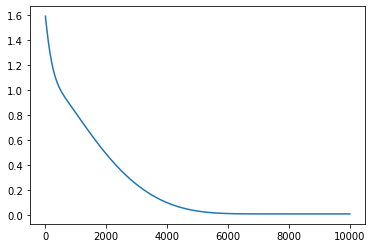

In [7]:
plt.plot(h)

In [8]:
pa, pb

(<tf.Variable 'a:0' shape=(1,) dtype=float64, numpy=array([-3.83933696])>,
 <tf.Variable 'b:0' shape=(1,) dtype=float64, numpy=array([1.92197143])>)

## `tensorflow` optimizer for MLE mixture of gaussians

In [9]:
gaus_pdf = lambda x, mu, sigma: np.exp(-0.5*((x-mu)/sigma)**2)/(sigma*np.sqrt(2*np.pi))

In [10]:
def get_random_params():
    m1,m2 = np.random.random(size=2)*2-1
    s1,s2 = np.random.random(size=2)*.2

    p1 = np.random.random()*.2+.3
    return np.r_[m1,m2,s1,s2,p1]

m1,m2,s1,s2,p1 = get_random_params()
    
n = 10000
n1 = int(n*p1)
n2 = n-n1

x1 = np.random.normal(loc=m1, scale=s1, size=n1)
x2 = np.random.normal(loc=m2, scale=s2, size=n2)

x = np.random.permutation(np.concatenate((x1,x2)))
m1,m2,s1,s2,p1

(-0.30861438609904646,
 0.20520598542532942,
 0.1225717590036065,
 0.016476459920938446,
 0.4147336116924617)

In [11]:
mix_pdf = lambda x, m1,m2,s1,s2,p1: p1*gaus_pdf(x,m1,s1)+(1-p1)*gaus_pdf(x,m2,s2)
mix_logpdf = lambda x, m1,m2,s1,s2,p1: np.log(mix_pdf(x,m1,m2,s1,s2,p1)+np.float64(1e-100))

In [12]:
logprob = np.r_[[np.mean(mix_logpdf(x,*get_random_params())) for _ in range(1000)]]
logprob = logprob[(logprob>=np.percentile(logprob, 10))]

Text(0.5, 1.0, 'mean logprob for 900 random params, showing top 90%')

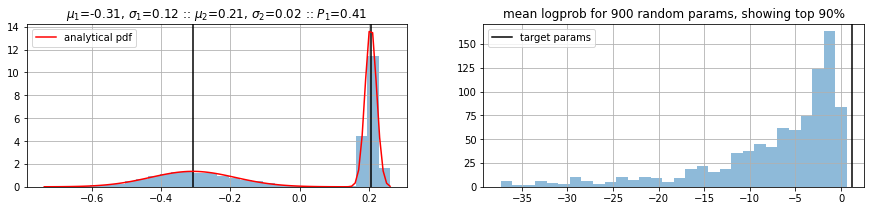

In [13]:
plt.figure(figsize=(15,3))
plt.subplot(121)
plt.hist(x, bins=30, alpha=.5, density=True);
plt.axvline(m1, color="black")
plt.axvline(m2, color="black")

xr = np.linspace(np.min(x), np.max(x), 100)
plt.plot(xr, mix_pdf(xr, m1,m2,s1,s2,p1), color="red", label="analytical pdf")
plt.legend(); plt.grid();
plt.title("$\mu_1$=%.2f, $\sigma_1$=%.2f :: $\mu_2$=%.2f, $\sigma_2$=%.2f :: $P_1$=%.2f"%(m1,s1,m2,s2,p1))

plt.subplot(122)
plt.hist(logprob, bins=30, alpha=.5);
plt.axvline(np.mean(mix_logpdf(x,m1,m2,s1,s2,p1)), color="black", label="target params")
plt.grid(); plt.legend();
plt.title("mean logprob for %d random params, showing top 90%s"%(len(logprob), '%'))

In [14]:
rm1, rm2, rs1, rs2, rp1 = get_random_params()*5-4

tm1 = tf.Variable(initial_value=[rm1], name="m1", dtype=tf.float64)
tm2 = tf.Variable(initial_value=[rm2], name="m2", dtype=tf.float64)
ts1 = tf.Variable(initial_value=[np.abs(rs1)], name="s1", dtype=tf.float64)
ts2 = tf.Variable(initial_value=[np.abs(rs2)], name="s2", dtype=tf.float64)
tp1 = tf.Variable(initial_value=[rp1], name="p1", dtype=tf.float64)
tfpi = tf.constant(np.pi, name="pi", dtype=tf.float64)

print ("m1", m1, tm1.numpy())
print ("m2", m2, tm2.numpy())
print ("s1", s1, ts1.numpy())
print ("s2", s2, ts2.numpy())
print ("p1", p1, tp1.numpy())

m1 -0.30861438609904646 [-1.31742141]
m2 0.20520598542532942 [-4.124501]
s1 0.1225717590036065 [3.64831478]
s2 0.016476459920938446 [3.28146655]
p1 0.4147336116924617 [-1.56796636]


In [15]:
# optimizer params fixing p1
# optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# optimizer params for all params free
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

x = x.astype(np.float64)
@tf.function
def train_step(x):
    
    gaus_pdf = lambda x, mu, sigma: tf.math.exp(-0.5*((x-mu)/sigma)**2)\
                                    /(sigma*tf.sqrt(2*tfpi))    
    
    mix_pdf = lambda x, m1,m2,s1,s2,p1: tf.sigmoid(.1*p1)*gaus_pdf(x,m1,s1)+(1-tf.sigmoid(.1*p1))*gaus_pdf(x,m2,s2)
    
    mix_logpdf = lambda x, m1,m2,s1,s2,p1: tf.math.log(mix_pdf(x,m1,m2,s1,s2,p1)+1e-100)
    
    with tf.GradientTape() as tape:
        loss_value = -tf.reduce_mean(mix_logpdf(x,tm1,tm2,ts1,ts2,tp1))
    grads = tape.gradient(loss_value, [tm1, tm2, ts1, ts2, tp1])
    optimizer.apply_gradients(zip(grads, [tm1, tm2, ts1, ts2, tp1]))
    
    
    return loss_value

In [16]:
h = []
for epoch in range(5000):
    loss_value = train_step(x)
    h.append(loss_value.numpy())

Text(0.5, 1.0, 'nan')

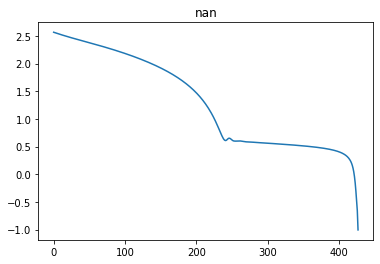

In [17]:
plt.plot(h)
plt.title(str(h[-1]))

In [18]:
print ("m1", m1, tm1.numpy())
print ("m2", m2, tm2.numpy())
print ("s1", s1, ts1.numpy())
print ("s2", s2, ts2.numpy())
print ("p1", p1, tf.sigmoid(.1*tp1).numpy())


m1 -0.30861438609904646 [0.20546284]
m2 0.20520598542532942 [-0.30817365]
s1 0.1225717590036065 [-0.01665899]
s2 0.016476459920938446 [-0.12458122]
p1 0.4147336116924617 [0.58517448]


In [19]:
tfpi = tf.constant(np.pi, name="pi", dtype=tf.float64)
gaus_pdf = lambda x, mu, sigma: tf.math.exp(-0.5*((x-mu)/sigma)**2)/(sigma*tf.sqrt(2*tfpi))    
exp_pdf  = lambda x, t: t * tf.math.exp(-t*x)

class MLE_GausMixture:
    
    def __init__(self):
        self.params = self.get_random_params()
        self.sf = .5 # sigmoid scaling factor
    
    def rvs(self, n):
        m1,m2,s1,s2,p1 = self.params
        
        n1 = int(n*tf.sigmoid(self.sf*p1).numpy())
        n2 = n-n1

        x1 = np.random.normal(loc=m1, scale=s1, size=n1)
        x2 = np.random.normal(loc=m2, scale=s2, size=n2)

        x = np.random.permutation(np.concatenate((x1,x2)))
        return x.astype(np.float64)
    
    def plot_sample(self, x):
        
        m1,m2,s1,s2,p1 = self.params        
        
        plt.hist(x, bins=30, alpha=.5, density=True);
        plt.axvline(m1, color="black")
        plt.axvline(m2, color="black")

        xr = np.linspace(np.min(x), np.max(x), 100)
        plt.plot(xr, np.exp(self.logprob(xr).numpy()), color="red", label="analytical pdf")
        plt.legend(); plt.grid();
        plt.title("$\mu_1$=%.2f, $\sigma_1$=%.2f :: $\mu_2$=%.2f, $\sigma_2$=%.2f\n$\sigma^{-1}(P_1)$=%.2f $P_1$=%.2f"%\
                  (m1,s1,m2,s2,p1, tf.sigmoid(self.sf*p1).numpy()))
    
    def get_random_params(self):
        m1,m2 = np.random.random(size=2)
        s1,s2 = np.abs(np.random.random(size=2)*.2)

        p1 = np.random.random()*6-3
        
        return np.r_[m1,m2,s1,s2,p1]

    def logprob(self, x, params=None):
            
        params = self.params if params is None else params
        m1, m2, s1, s2, p1 = params
        
        mix_pdf = lambda x, m1,m2,s1,s2,p1: tf.sigmoid(self.sf*p1)*gaus_pdf(x,m1,s1)\
                                            +(1-tf.sigmoid(self.sf*p1))*gaus_pdf(x,m2,s2)

        mix_logpdf = lambda x, m1,m2,s1,s2,p1: tf.math.log(mix_pdf(x,m1,m2,s1,s2,p1)+1e-100)

        r = mix_logpdf(x, *params)
        return r
    
    def init_optimizer(self, **optimizer_params):
        rm1, rm2, rs1, rs2, rp1 = self.get_random_params()*3
        rp1 = 0
        self.init_params=[rm1, rm2, rs1, rs2, rp1]
        
        self.tm1 = tf.Variable(initial_value=rm1, name="m1", dtype=tf.float64)
        self.tm2 = tf.Variable(initial_value=rm2, name="m2", dtype=tf.float64)
        self.ts1 = tf.Variable(initial_value=rs1, name="s1", dtype=tf.float64)
        self.ts2 = tf.Variable(initial_value=rs2, name="s2", dtype=tf.float64)
        self.tp1 = tf.Variable(initial_value=rp1, name="p1", dtype=tf.float64)

        self.tparams = [self.tm1, self.tm2, self.ts1, self.ts2, self.tp1]
        
        self.optimizer = tf.optimizers.Adam(**optimizer_params)

        @tf.function
        def train_step(x):
            
            loss = lambda x, params: -self.logprob(x,params)
            
            with tf.GradientTape() as tape:
                loss_value = tf.reduce_mean(loss(x,self.tparams))

            grads = tape.gradient(loss_value, self.tparams)
            self.optimizer.apply_gradients(zip(grads, self.tparams))

            return loss_value
        
        self.train_step = train_step
        
        self.history = []
        
        
    def fit(self, x, n_steps=5000):
        self.history_lastbatch = []
        for epoch in pbar(range(n_steps)):
            loss_value = self.train_step(x)
            self.history_lastbatch.append(loss_value.numpy())
            self.history.append(loss_value.numpy())
            
    def print_values(self):
        print ("param     obtained  true_value")
        for a,b in zip(self.tparams, self.params):
            print (a.name.split(":")[0], "    %8.3f  %8.3f"%(a.numpy(), b))        

array([ 0.23358411,  0.57757253,  0.05290956,  0.03510515, -1.92439543])

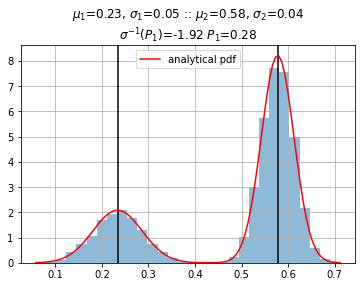

In [20]:
m = MLE_GausMixture()
x = m.rvs(10000)
m.plot_sample(x)
m.params

In [21]:
m.init_optimizer()
m.tparams

[<tf.Variable 'm1:0' shape=() dtype=float64, numpy=1.1778190649400457>,
 <tf.Variable 'm2:0' shape=() dtype=float64, numpy=2.462421582122195>,
 <tf.Variable 's1:0' shape=() dtype=float64, numpy=0.04331112429723627>,
 <tf.Variable 's2:0' shape=() dtype=float64, numpy=0.18338952205309422>,
 <tf.Variable 'p1:0' shape=() dtype=float64, numpy=0.0>]

100% (10000 of 10000) |##################| Elapsed Time: 0:00:03 Time:  0:00:03


param     obtained  true_value
m1        0.483     0.234
m2        2.420     0.578
s1        0.159     0.053
s2        0.225     0.035
p1        7.218    -1.924


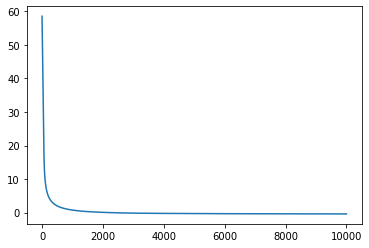

In [22]:
m.fit(x, n_steps=10000)
plt.plot(m.history_lastbatch)
m.print_values()

In [23]:
t, mu_s, sigma_s, mu = 0.03, 60, 6, .1
m = h2.MLE_SignalBg([t, mu_s, sigma_s, mu])
x = m.rvs(10000)

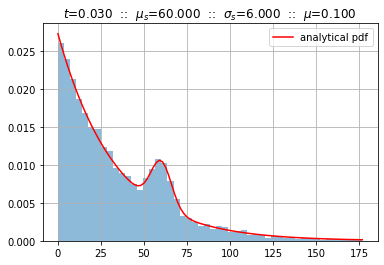

In [24]:
m.plot_sample(x, bins=50)

### optimization with all params free

In [25]:
m.init_optimizer(learning_rate=.001)
m.tparams

[<tf.Variable 't:0' shape=() dtype=float64, numpy=0.17906775579663126>,
 <tf.Variable 'mu_s:0' shape=() dtype=float64, numpy=38.37863284797883>,
 <tf.Variable 'sigma_s:0' shape=() dtype=float64, numpy=7.018877165010157>,
 <tf.Variable 'mu:0' shape=() dtype=float64, numpy=0.0002350626459827514>]

In [26]:
m.likelihood(x, m.tparams).numpy(), m.likelihood(x, m.params).numpy()

(8.059106357484112, 4.542987525723905)

100% (30000 of 30000) |##################| Elapsed Time: 0:00:10 Time:  0:00:10


   param     obtained  true_value
       t        0.030     0.030
    mu_s       54.050    60.000
 sigma_s       11.152     6.000
      mu       -0.130     0.100


4.551513873822785

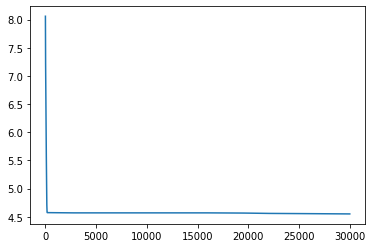

In [27]:
m.fit(x, n_steps=30000)
plt.plot(m.history_lastbatch)
m.print_values()
m.likelihood(x, m.tparams).numpy()

shape of distribution of the obtained parameters

In [28]:
m2 = MLE_SignalBg([i.numpy() for i in m.tparams])
m2.plot_sample(m2.rvs(10000), bins=50)
plt.show()

NameError: name 'MLE_SignalBg' is not defined

### optimization with only $\mu$ free

In [ ]:
m.init_optimizer(learning_rate=.001, fixed_params=["t", "mu_s", "sigma_s"])
m.tparams

In [ ]:
m.free_params

In [ ]:
m.likelihood(x, m.tparams).numpy(), m.likelihood(x, m.params).numpy()

In [ ]:
m.fit(x, n_steps=30000)
plt.plot(m.history_lastbatch)
m.print_values()
m.likelihood(x, m.tparams).numpy()

## inspecting likelihood ratio

this is the real data (no signal)

In [ ]:
p1 = np.r_[0.03, 60, 6, 0]
m1 = MLE_SignalBg(p1)
x1 = m1.rvs(10000)
m1.plot_sample(x1)

however our theory predicts this

In [ ]:
p2 = np.r_[0.03, 80, 5, 0.3]
m2 = MLE_SignalBg(p2)
m2.plot_sample(x1)

MLE with all free params

In [ ]:
m2.init_optimizer(learning_rate=.001)
m2.fit(x1, n_steps=30000)
plt.plot(m2.history_lastbatch)
m2.print_values()
m2.likelihood(x1, m2.tparams).numpy()

MLE with only $\mu$ free

In [ ]:
m2.init_optimizer(learning_rate=.001, fixed_params=["t", "mu_s", "sigma_s"])
m2.fit(x1, n_steps=30000)
plt.plot(m2.history_lastbatch)
m2.print_values()
m2.likelihood(x1, m2.tparams).numpy()

### the following set of parameters have similar likelihoods 

In [29]:
p1 = np.r_[ 0.05, 60, 6, .3]
p2 = np.r_[0.034, 11.996, 5.738, 0]

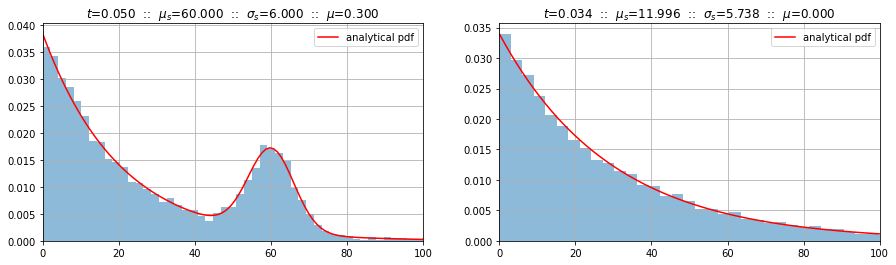

In [31]:
plt.figure(figsize=(15,4))
plt.subplot(121)
k1 = h2.MLE_SignalBg(p1)
x1 = k1.rvs(10000)
k1.plot_sample(x1, bins=50)
plt.xlim(0,100)
plt.subplot(122)
k2 = h2.MLE_SignalBg(p2)
x2 = k2.rvs(10000)
k2.plot_sample(x2, bins=50)
plt.xlim(0,100)
plt.show()

observe how likelihood are very close for both parameter sets even if the underlying distribution is very different

In [33]:
k1.likelihood(x1,p1).numpy(), k1.likelihood(x1,p2).numpy()

(4.209092814222311, 4.371225989820003)